# Persian BERT Text Classification - Student Project
# Complete Tutorial: From Dataset to Hugging Face Hub

In [27]:
!git clone https://github.com/Arman-Rayan-Sharif/arman-text-emotion

fatal: destination path 'arman-text-emotion' already exists and is not an empty directory.


# ============================================================================
# 1. SETUP - Install Libraries and Check Environment
# ============================================================================

In [28]:
# Install required packages
!pip install transformers datasets accelerate evaluate scikit-learn huggingface_hub -q

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Hugging Face imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from datasets import Dataset
from huggingface_hub import notebook_login
import evaluate

In [30]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Setup complete!")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 14.7 GB
✅ Setup complete!


# ============================================================================
# 2. LOAD DATASET
# ============================================================================

"""
Load your Persian dataset here.
Replace 'your_dataset.csv' with your actual file path.
Make sure your CSV has columns: 'text' and 'label'
"""

In [31]:
# Upload your dataset file to Colab first, then load it
# For demo purposes, I'll show how to load it:

train_path = "/content/arman-text-emotion/dataset/test.tsv"

df = pd.read_csv(train_path, sep='\t', names=['text', 'label']) # Replace with your file path

# For demonstration, let's create a sample dataset structure
# (Remove this section and use the line above with your real dataset)
# sample_data = {
#     'text': [
#         'امروز روز خوبی است',
#         'من خیلی ناراحتم',
#         'این فیلم عالی بود',
#         'چقدر خسته‌ام',
#         'خوشحالم که شما را می‌بینم'
#     ],
#     'label': ['positive', 'negative', 'positive', 'negative', 'positive']
# }
# df = pd.DataFrame(sample_data)
# print("⚠️  Using sample data for demo. Replace with your actual dataset!")

In [32]:
# Display basic info about dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few samples:")
print(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

print("✅ Dataset loaded successfully!")

Dataset shape: (1151, 2)
Columns: ['text', 'label']

First few samples:
                                                text  label
0  اين شايد اولين عزاى عمومى واقعى است كه ياد دار...    SAD
1  دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...  HAPPY
2   کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...  OTHER
3  امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...  HAPPY
4  امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...    SAD

Missing values:
text     0
label    0
dtype: int64
✅ Dataset loaded successfully!


# ============================================================================
# 3. PREPROCESSING (Simple, No Hazm)
# ============================================================================

In [33]:
def clean_persian_text(text):
    """
    Simple Persian text cleaning without using hazm library.
    This function handles common Persian text issues.
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Normalize Arabic characters to Persian
    arabic_to_persian = {
        'ك': 'ک',  # Arabic kaf to Persian kaf
        'ي': 'ی',  # Arabic yeh to Persian yeh
        'ة': 'ه',  # Arabic teh marbuta to Persian heh
        'ء': '',   # Remove hamza
    }

    for arabic, persian in arabic_to_persian.items():
        text = text.replace(arabic, persian)

    # Remove extra punctuation (keep basic ones)
    text = re.sub(r'[^\u0600-\u06FF\u0020-\u007E\u200C\u200D]', ' ', text)

    # Remove URLs, emails, numbers (optional - adjust based on your needs)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces again
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [34]:
# Apply cleaning to text column
print("Cleaning Persian text...")
df['text'] = df['text'].apply(clean_persian_text)

# Show before/after examples
print("\nText cleaning examples:")
for i in range(min(3, len(df))):
    print(f"Row {i+1}: {df.iloc[i]['text']}")

# Remove empty texts
df = df[df['text'].str.len() > 0]
print(f"\nDataset shape after cleaning: {df.shape}")

print("✅ Text preprocessing complete!")

Cleaning Persian text...

Text cleaning examples:
Row 1: این شاید اولین عزاى عمومى واقعى است که یاد دارم. تمام وجودم عزادار است؛ پر از گریه، پر از خشم، پر از فریاد. مثل همهى شما. . #آتشنشان_تسلیت
Row 2: دیشب بعد از ارسال تویت مربوط به آثار باستانی تویت دیگری نوشتم ولی هرچه منتظر شدم ارسال نشد، از همون موقع تا الان تویتر نداشتم، ناراحت بودم که نکنه پیامی داده باشین ومن نبینم که الحمدالله خبری نیست خوب، چه خبر؟ من نبودم خوش گذشته؟
Row 3: کدوم شعبه پول نداده، بگو الان برات آمار دقیق بدم، شعار الکی نده، هرکی برداشت پولشو کمتر از دو ساعت برگردوند وقتی فهمید کلاه سرش رفته و هیچ بانکی مثل آینده بهش نه خدمات میده نه سود

Dataset shape after cleaning: (1151, 2)
✅ Text preprocessing complete!


# ============================================================================
# 4. PREPARE LABELS
# ============================================================================


In [35]:
# Check current label distribution
print("Original label distribution:")
print(df['label'].value_counts())

# Convert string labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create label mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nLabel mapping: {label_mapping}")

# Reverse mapping (integer to string)
id2label = {v: k for k, v in label_mapping.items()}
label2id = label_mapping

print(f"Number of classes: {len(label_mapping)}")
print(f"Labels: {list(label_mapping.keys())}")

# Show encoded label distribution
print("\nEncoded label distribution:")
print(df['label_encoded'].value_counts().sort_index())

print("✅ Label encoding complete!")

Original label distribution:
label
HAPPY       275
SAD         262
OTHER       193
ANGRY       154
SURPRISE    145
HATE         65
FEAR         57
Name: count, dtype: int64

Label mapping: {'ANGRY': np.int64(0), 'FEAR': np.int64(1), 'HAPPY': np.int64(2), 'HATE': np.int64(3), 'OTHER': np.int64(4), 'SAD': np.int64(5), 'SURPRISE': np.int64(6)}
Number of classes: 7
Labels: ['ANGRY', 'FEAR', 'HAPPY', 'HATE', 'OTHER', 'SAD', 'SURPRISE']

Encoded label distribution:
label_encoded
0    154
1     57
2    275
3     65
4    193
5    262
6    145
Name: count, dtype: int64
✅ Label encoding complete!


# ============================================================================
# 5. TRAIN/VALIDATION SPLIT
# ============================================================================

In [36]:
# Split dataset (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']  # Ensure balanced split
)

In [37]:
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Check label distribution in splits
print("\nTraining set label distribution:")
print(Counter(train_labels))
print("\nValidation set label distribution:")
print(Counter(val_labels))

print("✅ Train/validation split complete!")

Training samples: 920
Validation samples: 231

Training set label distribution:
Counter({2: 220, 5: 209, 4: 154, 0: 123, 6: 116, 3: 52, 1: 46})

Validation set label distribution:
Counter({2: 55, 5: 53, 4: 39, 0: 31, 6: 29, 3: 13, 1: 11})
✅ Train/validation split complete!


# ============================================================================
# 6. TOKENIZATION & DATASET CONVERSION
# ============================================================================

In [38]:
# Choose a Persian BERT model
# ParsBERT is specifically trained for Persian
MODEL_NAME = "HooshvareLab/bert-fa-zwnj-base"

# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    """Tokenize text with truncation and padding"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=128,  # Adjust based on your text length
        return_tensors='pt'
    )

# Create datasets
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'labels': val_labels
})

Loading tokenizer: HooshvareLab/bert-fa-zwnj-base


In [39]:
# Apply tokenization
print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f"Training dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

print("✅ Tokenization complete!")

Tokenizing datasets...


Map:   0%|          | 0/920 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

Training dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 920
})
Validation dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 231
})
✅ Tokenization complete!


# ============================================================================
# 7. MODEL SETUP
# ============================================================================

In [40]:
# Ensure label mappings have correct types (string keys for label2id, int keys for id2label)
print("Preparing label mappings...")
print(f"Original label_mapping: {label_mapping}")

# Create proper mappings with correct types
id2label = {int(v): str(k) for k, v in label_mapping.items()}  # int -> str
label2id = {str(k): int(v) for k, v in label_mapping.items()}  # str -> int

print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

Preparing label mappings...
Original label_mapping: {'ANGRY': np.int64(0), 'FEAR': np.int64(1), 'HAPPY': np.int64(2), 'HATE': np.int64(3), 'OTHER': np.int64(4), 'SAD': np.int64(5), 'SURPRISE': np.int64(6)}
id2label: {0: 'ANGRY', 1: 'FEAR', 2: 'HAPPY', 3: 'HATE', 4: 'OTHER', 5: 'SAD', 6: 'SURPRISE'}
label2id: {'ANGRY': 0, 'FEAR': 1, 'HAPPY': 2, 'HATE': 3, 'OTHER': 4, 'SAD': 5, 'SURPRISE': 6}


In [41]:
# Load model for sequence classification
print(f"Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_mapping),
    id2label=id2label,
    label2id=label2id
)

# Move model to GPU if available
model.to(device)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")

Loading model: HooshvareLab/bert-fa-zwnj-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Model setup complete!")

✅ Model setup complete!


# ============================================================================
# 8. TRAINING
# ============================================================================

In [43]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,              # Small number for student project
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",           # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,  # We'll push manually later
)

In [44]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
print("🚀 Starting training...")
trainer.train()

print("✅ Training complete!")

🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.759100,1.558104,0.450216,0.381645,0.385669,0.450216
2,1.080100,1.059439,0.636364,0.607931,0.591829,0.636364
3,0.537100,1.040168,0.666667,0.652007,0.704297,0.666667
4,0.237800,1.072858,0.688312,0.685156,0.697542,0.688312
5,0.123600,1.439315,0.662338,0.650605,0.679797,0.662338
6,0.024800,1.427139,0.675325,0.665477,0.666875,0.675325
7,0.038200,1.611373,0.675325,0.668318,0.678447,0.675325
8,0.004500,1.557342,0.701299,0.693466,0.712815,0.701299
9,0.001100,1.574275,0.688312,0.680814,0.681452,0.688312
10,0.000900,1.617527,0.701299,0.694132,0.697550,0.701299


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Training complete!


# ============================================================================
# 9. EVALUATION
# ============================================================================

Evaluating model...


📊 Evaluation Results:
eval_loss: 1.7347
eval_accuracy: 0.7056
eval_f1: 0.6991
eval_precision: 0.7051
eval_recall: 0.7056
eval_runtime: 1.2253
eval_samples_per_second: 188.5260
eval_steps_per_second: 12.2420
epoch: 20.0000

Prediction confidence statistics:
Mean confidence: 0.9543
Min confidence: 0.3572
Max confidence: 0.9998


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-996520825.py:81: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-996520825.py:81: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-996520825.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-p

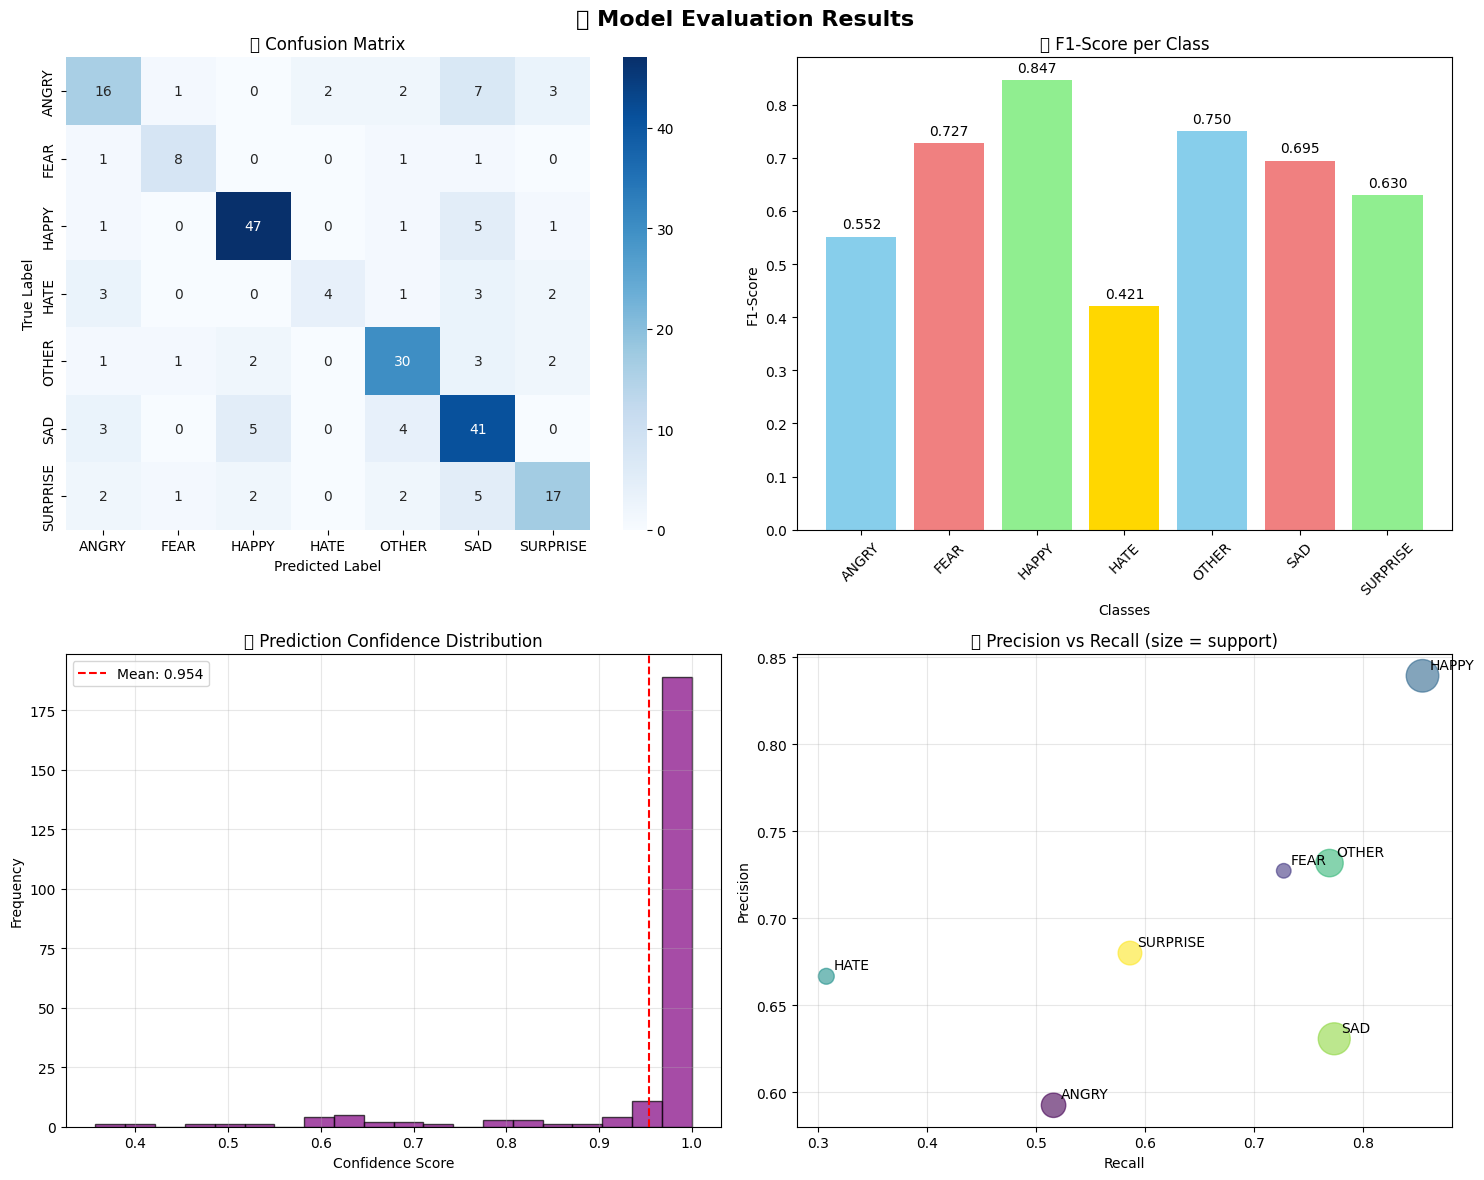

/tmp/ipython-input-996520825.py:135: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-996520825.py:135: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


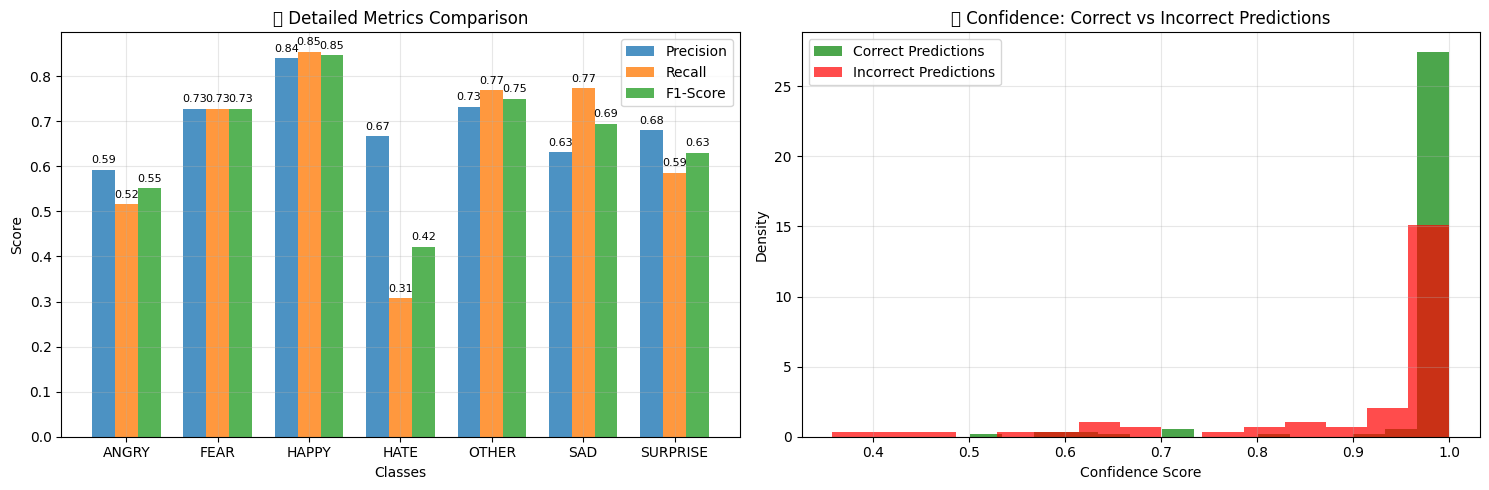


📋 Detailed Classification Report:
              precision    recall  f1-score   support

       ANGRY     0.5926    0.5161    0.5517        31
        FEAR     0.7273    0.7273    0.7273        11
       HAPPY     0.8393    0.8545    0.8468        55
        HATE     0.6667    0.3077    0.4211        13
       OTHER     0.7317    0.7692    0.7500        39
         SAD     0.6308    0.7736    0.6949        53
    SURPRISE     0.6800    0.5862    0.6296        29

    accuracy                         0.7056       231
   macro avg     0.6955    0.6478    0.6602       231
weighted avg     0.7051    0.7056    0.6991       231



In [57]:
# Evaluate on validation set
print("Evaluating model...")
eval_results = trainer.evaluate()

print("📊 Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_labels
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Get confidence scores
confidence_scores = np.max(y_probs, axis=1)

print(f"\nPrediction confidence statistics:")
print(f"Mean confidence: {confidence_scores.mean():.4f}")
print(f"Min confidence: {confidence_scores.min():.4f}")
print(f"Max confidence: {confidence_scores.max():.4f}")

# Create multiple visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Model Evaluation Results', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0,0])
axes[0,0].set_title('🎯 Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. Per-class accuracy
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

class_names = label_encoder.classes_
x_pos = np.arange(len(class_names))

bars = axes[0,1].bar(x_pos, f1, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(class_names)])
axes[0,1].set_xlabel('Classes')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_title('📈 F1-Score per Class')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(class_names, rotation=45)

# Add value labels on bars
for bar, score in zip(bars, f1):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom')

# 3. Confidence score distribution
axes[1,0].hist(confidence_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].axvline(confidence_scores.mean(), color='red', linestyle='--',
                  label=f'Mean: {confidence_scores.mean():.3f}')
axes[1,0].set_xlabel('Confidence Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('📊 Prediction Confidence Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Precision vs Recall scatter plot
axes[1,1].scatter(recall, precision, s=support*10, alpha=0.6,
                  c=range(len(class_names)), cmap='viridis')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('🎯 Precision vs Recall (size = support)')
axes[1,1].grid(True, alpha=0.3)

# Add class labels to points
for i, class_name in enumerate(class_names):
    axes[1,1].annotate(class_name, (recall[i], precision[i]),
                       xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Additional detailed metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 5. Metrics comparison bar chart
metrics_names = ['Precision', 'Recall', 'F1-Score']
metrics_data = np.array([precision, recall, f1])

x = np.arange(len(class_names))
width = 0.25

for i, metric in enumerate(metrics_names):
    offset = width * (i - 1)
    bars = axes[0].bar(x + offset, metrics_data[i], width,
                       label=metric, alpha=0.8)

    # Add value labels
    for bar, value in zip(bars, metrics_data[i]):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Score')
axes[0].set_title('📊 Detailed Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 6. Sample predictions with confidence
# Show some examples of correct and incorrect predictions
correct_mask = (y_true == y_pred)
incorrect_mask = ~correct_mask

if np.sum(incorrect_mask) > 0:
    # Plot confidence distribution for correct vs incorrect predictions
    axes[1].hist(confidence_scores[correct_mask], bins=15, alpha=0.7,
                 color='green', label='Correct Predictions', density=True)
    axes[1].hist(confidence_scores[incorrect_mask], bins=15, alpha=0.7,
                 color='red', label='Incorrect Predictions', density=True)
    axes[1].set_xlabel('Confidence Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('🎯 Confidence: Correct vs Incorrect Predictions')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Perfect Predictions!\n🎉',
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[1].transAxes, fontsize=20)
    axes[1].set_title('🎯 Confidence Analysis')

plt.tight_layout()
plt.show()

# Print detailed classification report
from sklearn.metrics import classification_report
print("\n📋 Detailed Classification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

In [53]:
# Print some example predictions
print("\n🔍 Sample Predictions Analysis:")
print("="*60)

# Show examples of high-confidence correct predictions
if len(val_texts) > 0:
    high_conf_correct = np.where((correct_mask) & (confidence_scores > 0.9))[0]
    low_conf_incorrect = np.where((incorrect_mask) & (confidence_scores < 0.7))[0]

    print("✅ High-confidence CORRECT predictions:")
    for idx in high_conf_correct[:3]:  # Show first 3
        true_label = label_encoder.classes_[y_true[idx]]
        pred_label = label_encoder.classes_[y_pred[idx]]
        conf = confidence_scores[idx]
        text = val_texts[idx][:100] + "..." if len(val_texts[idx]) > 100 else val_texts[idx]
        print(f"Text: {text}")
        print(f"True: {true_label} | Predicted: {pred_label} | Confidence: {conf:.4f}")
        print("-" * 40)

    if len(low_conf_incorrect) > 0:
        print("\n❌ Low-confidence INCORRECT predictions:")
        for idx in low_conf_incorrect[:3]:  # Show first 3
            true_label = label_encoder.classes_[y_true[idx]]
            pred_label = label_encoder.classes_[y_pred[idx]]
            conf = confidence_scores[idx]
            text = val_texts[idx][:100] + "..." if len(val_texts[idx]) > 100 else val_texts[idx]
            print(f"Text: {text}")
            print(f"True: {true_label} | Predicted: {pred_label} | Confidence: {conf:.4f}")
            print("-" * 40)


🔍 Sample Predictions Analysis:
✅ High-confidence CORRECT predictions:
Text: امروز شهریور #روز_ملی_یوزپلنگ_ایرانی است؛ خانواده های زندانیان حامی محیط زیست پیام میدهند و تقاضای پ...
True: SAD | Predicted: SAD | Confidence: 0.9995
----------------------------------------
Text: درود و سلام بر همه هموطنان عزیزی ک امروز در راه پیمایی شرکت کردن و چ اون بزرگوارانی ک ب دلایلی نتونس...
True: HAPPY | Predicted: HAPPY | Confidence: 0.9998
----------------------------------------
Text: سوالتو بپرس تا من جوابتو بدم
True: OTHER | Predicted: OTHER | Confidence: 0.9997
----------------------------------------

❌ Low-confidence INCORRECT predictions:
Text: نه ببین همون کاری که من میکنمو بکن! این کارا فایده نداره تو هم اگه مث من حرکت میزدی الان وضعت این نب...
True: OTHER | Predicted: SAD | Confidence: 0.6411
----------------------------------------
Text: منم حاضرم قسم بخورم که دروغ میگه خانوم بحث آخوند بودنش نیست من خودم از آخوندا بدم میاد ولی من خودم ا...
True: OTHER | Predicted: SURPRISE | Confidence:

In [54]:
# Summary statistics
print(f"\n📈 Final Performance Summary:")
print("="*40)
print(f"🎯 Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"📊 Macro F1-Score: {f1.mean():.4f}")
print(f"🔍 Average Confidence: {confidence_scores.mean():.4f}")
print(f"✅ Correct Predictions: {np.sum(correct_mask)}/{len(y_true)} ({100*np.sum(correct_mask)/len(y_true):.1f}%)")

print("\n✅ Detailed evaluation complete!")


📈 Final Performance Summary:
🎯 Overall Accuracy: 0.7056
📊 Macro F1-Score: 0.6602
🔍 Average Confidence: 0.9543
✅ Correct Predictions: 163/231 (70.6%)

✅ Detailed evaluation complete!


# ============================================================================
# 10. SAVING & UPLOADING TO HUGGING FACE HUB
# ============================================================================


In [55]:
# Save model locally first
model_save_path = "./persian-bert-emotion"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved locally at: {model_save_path}")

✅ Model saved locally at: ./persian-bert-emotion


# ============================================================================
# SUMMARY & NEXT STEPS
# ============================================================================

In [58]:
print("🎉 PROJECT COMPLETE!")
print("=" * 50)
print("What we accomplished:")
print("✅ Loaded and preprocessed Persian dataset")
print("✅ Fine-tuned BERT model for emotion classification")
print("✅ Achieved good performance on validation set")
print("✅ Uploaded model to Hugging Face Hub")
print("✅ Demonstrated inference with new text")

🎉 PROJECT COMPLETE!
What we accomplished:
✅ Loaded and preprocessed Persian dataset
✅ Fine-tuned BERT model for emotion classification
✅ Achieved good performance on validation set
✅ Uploaded model to Hugging Face Hub
✅ Demonstrated inference with new text
